In [18]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import csv
import re
import pandas as pd
import pathlib

In [1]:
import os

In [3]:
os.chdir('../')

In [5]:
os.getcwd()

'c:\\Users\\Willi\\Documents\\GitHub\\specsim'

In [6]:
from specsim.contrast import *

Plotting functions from Dimitri

In [19]:
def radial_profile(data, center):
    """ Calculate the radial profile of a 2D array. """
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)

    # Define the desired thickness
    thickness = 4  # thickness in pixels
    
    # Bin the pixel values by their distances
    r_flat = r.ravel()
    image_flat = data.ravel()
    # Define bin edges with the desired thickness
    bin_edges = np.arange(0, r.max() + thickness, thickness)

    # Calculate the mean intensity within each bin
    radial_profile, bin_edges, binnumber = binned_statistic(r_flat, image_flat, statistic='mean', bins=bin_edges)

    # Calculate bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return radial_profile, bin_centers

In [20]:
def process_fits_file(file_path):
    """ Process a single FITS file and return the radial profiles. """
    with fits.open(file_path) as hdul:  
        profiles = {}
        bin_centers = {}
        dp = {}
        for i in range(0, len(hdul)):
            dp [f'extension_{i}'] = hdul[i].header['DP']
            data = hdul[i].data
            center = (data.shape[1] // 2, data.shape[0] // 2)
            profiles[f'extension_{i}'], bin_centers[f'extension_{i}'] = radial_profile(data, center)
    return profiles, bin_centers, dp

This return has three dictionaries. Indexing the first will give the profiles for each of the four extensions, and so on for bin_centers and dp

In [21]:
test_path = "D:/mcao_pyttf/25p_za0/mag12/evlpsfcl_1_x0_y0.fits"
# process_fits_file(test_path)

In [22]:
print(process_fits_file(test_path)[2])

{'extension_0': 0.00360963, 'extension_1': 0.00429718, 'extension_2': 0.00567228, 'extension_3': 0.00756304}


In [23]:
# def process_fits_scale(file_path):
#     """ Process a single FITS file and return the scale and dimensions. """
#     with fits.open(file_path) as hdul:  
#         dimensions = {}
#         dp = {}
#         for i in range(0, len(hdul)):
#             dp [f'extension_{i}'] = hdul[i].header['DP']
#             data = hdul[i].data
#             dimensions[f'extension_{i}'] = data.shape
#     return dimensions, dp

In [24]:
def error_handled_fits(file_path):
    """Process a single FITS file and return the radius and profiles."""
    try:
        # Check if the file is empty (size is 0)
        if os.path.getsize(file_path) == 0:
            raise ValueError(f"File {file_path} is empty.")
        else:
            # Attempt to open the file with fits.open() if it's not empty
            with fits.open(file_path) as hdul:  
                profiles = {}
                bin_centers = {}
                dp = {}
                radii = {}
                for i in range(0, len(hdul)):
                    dp [f'extension_{i}'] = hdul[i].header['DP']
                    data = hdul[i].data
                    center = (data.shape[1] // 2, data.shape[0] // 2)
                    profiles[f'extension_{i}'], bin_centers[f'extension_{i}'] = radial_profile(data, center)
                    radii[f'extension_{i}'] = bin_centers[f'extension_{i}'] * dp[f'extension_{i}'] # convert pixels to angular separation in arcsec
            return radii, profiles
        
    except ValueError as e:
        # Handle the case where the file is empty
        print(e)
    except Exception as e:
        # Handle other exceptions, such as file not found
        print(f"An error occurred: {e}")

In [25]:
# root_directory = "D:/mcao_pyttf/25p_za0/mag16"
# output_directory = "C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files"
# convert_files_to_csv(root_directory, output_directory)
error_handled_fits('D:/mcao_pyttf/75p_za60/mag22/evlpsfcl_1_x0_y0.fits')

File D:/mcao_pyttf/75p_za60/mag22/evlpsfcl_1_x0_y0.fits is empty.


In [26]:
result = error_handled_fits('D:/mcao_pyttf/75p_za60/mag15/evlpsfcl_1_x0_y0.fits')
print(result)

KeyboardInterrupt: 

In [ ]:
# Now do this through an entire directory
def error_handled_directory(directory):
    """ Process all FITS files in the given directory and subdirectories to give radii and profiles. """
    results = {}
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('x0_y0.fits'):
                file_path = os.path.join(root, file)
                radii, profiles = error_handled_fits(file_path)
                rel_dir = os.path.relpath(root, directory)
                if rel_dir not in results:
                    results[rel_dir] = []
                radii = np.array
                results[rel_dir].append((file, radii, profiles))
    return results

In [ ]:
test_dict_radii = error_handled_fits(test_path)[0]
# print(test_dict_radii)
print(test_dict_radii.get('extension_0'))

[7.21926000e-03 2.16577800e-02 3.60963000e-02 5.05348200e-02
 6.49733400e-02 7.94118600e-02 9.38503800e-02 1.08288900e-01
 1.22727420e-01 1.37165940e-01 1.51604460e-01 1.66042980e-01
 1.80481500e-01 1.94920020e-01 2.09358540e-01 2.23797060e-01
 2.38235580e-01 2.52674100e-01 2.67112620e-01 2.81551140e-01
 2.95989660e-01 3.10428180e-01 3.24866700e-01 3.39305220e-01
 3.53743740e-01 3.68182260e-01 3.82620780e-01 3.97059300e-01
 4.11497820e-01 4.25936340e-01 4.40374860e-01 4.54813380e-01
 4.69251900e-01 4.83690420e-01 4.98128940e-01 5.12567460e-01
 5.27005980e-01 5.41444500e-01 5.55883020e-01 5.70321540e-01
 5.84760060e-01 5.99198580e-01 6.13637100e-01 6.28075620e-01
 6.42514140e-01 6.56952660e-01 6.71391180e-01 6.85829700e-01
 7.00268220e-01 7.14706740e-01 7.29145260e-01 7.43583780e-01
 7.58022300e-01 7.72460820e-01 7.86899340e-01 8.01337860e-01
 8.15776380e-01 8.30214900e-01 8.44653420e-01 8.59091940e-01
 8.73530460e-01 8.87968980e-01 9.02407500e-01 9.16846020e-01
 9.31284540e-01 9.457230

In [ ]:
len(list(test_dict_radii.values()))

4

In [ ]:
list(test_dict_radii.values())

[array([7.21926000e-03, 2.16577800e-02, 3.60963000e-02, 5.05348200e-02,
        6.49733400e-02, 7.94118600e-02, 9.38503800e-02, 1.08288900e-01,
        1.22727420e-01, 1.37165940e-01, 1.51604460e-01, 1.66042980e-01,
        1.80481500e-01, 1.94920020e-01, 2.09358540e-01, 2.23797060e-01,
        2.38235580e-01, 2.52674100e-01, 2.67112620e-01, 2.81551140e-01,
        2.95989660e-01, 3.10428180e-01, 3.24866700e-01, 3.39305220e-01,
        3.53743740e-01, 3.68182260e-01, 3.82620780e-01, 3.97059300e-01,
        4.11497820e-01, 4.25936340e-01, 4.40374860e-01, 4.54813380e-01,
        4.69251900e-01, 4.83690420e-01, 4.98128940e-01, 5.12567460e-01,
        5.27005980e-01, 5.41444500e-01, 5.55883020e-01, 5.70321540e-01,
        5.84760060e-01, 5.99198580e-01, 6.13637100e-01, 6.28075620e-01,
        6.42514140e-01, 6.56952660e-01, 6.71391180e-01, 6.85829700e-01,
        7.00268220e-01, 7.14706740e-01, 7.29145260e-01, 7.43583780e-01,
        7.58022300e-01, 7.72460820e-01, 7.86899340e-01, 8.013378

In [ ]:
contrast_path = "C:/Users/Willi/Documents/GitHub/specsim/data/contrast/"
os.chdir(contrast_path)
# os.getcwd()
array = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
test_csv = "renamed_test_csv.csv"
full_path = os.path.join(contrast_path, test_csv)

with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(array)  # Use writerow for a single row

print(f"Array written to {full_path}")

Array written to C:/Users/Willi/Documents/GitHub/specsim/data/contrast/renamed_test_csv.csv


In [ ]:
os.rename("test_csv.csv", "renamed_test_csv.csv")

In [ ]:
test_dict_radii = error_handled_fits(test_path)[3]
# print(test_dict_radii
print(test_dict_radii.get('extension_0'))

[7.21926000e-03 2.16577800e-02 3.60963000e-02 5.05348200e-02
 6.49733400e-02 7.94118600e-02 9.38503800e-02 1.08288900e-01
 1.22727420e-01 1.37165940e-01 1.51604460e-01 1.66042980e-01
 1.80481500e-01 1.94920020e-01 2.09358540e-01 2.23797060e-01
 2.38235580e-01 2.52674100e-01 2.67112620e-01 2.81551140e-01
 2.95989660e-01 3.10428180e-01 3.24866700e-01 3.39305220e-01
 3.53743740e-01 3.68182260e-01 3.82620780e-01 3.97059300e-01
 4.11497820e-01 4.25936340e-01 4.40374860e-01 4.54813380e-01
 4.69251900e-01 4.83690420e-01 4.98128940e-01 5.12567460e-01
 5.27005980e-01 5.41444500e-01 5.55883020e-01 5.70321540e-01
 5.84760060e-01 5.99198580e-01 6.13637100e-01 6.28075620e-01
 6.42514140e-01 6.56952660e-01 6.71391180e-01 6.85829700e-01
 7.00268220e-01 7.14706740e-01 7.29145260e-01 7.43583780e-01
 7.58022300e-01 7.72460820e-01 7.86899340e-01 8.01337860e-01
 8.15776380e-01 8.30214900e-01 8.44653420e-01 8.59091940e-01
 8.73530460e-01 8.87968980e-01 9.02407500e-01 9.16846020e-01
 9.31284540e-01 9.457230

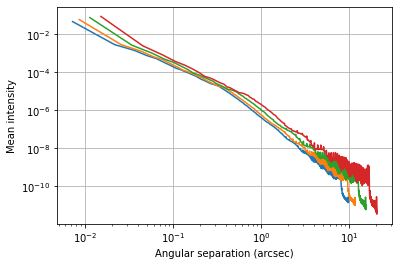

In [ ]:
plt.xlabel('Angular separation (arcsec)')
plt.ylabel('Mean intensity')
plt.loglog(test_dict_radii.get('extension_0'), test_dict_profile.get('extension_0'))
plt.loglog(test_dict_radii.get('extension_1'), test_dict_profile.get('extension_1'))
plt.loglog(test_dict_radii.get('extension_2'), test_dict_profile.get('extension_2'))
plt.loglog(test_dict_radii.get('extension_3'), test_dict_profile.get('extension_3'))

plt.grid()
plt.show()

In [ ]:
process_fits_scale(test_path)

({'extension_0': (3840, 3840),
  'extension_1': (3840, 3840),
  'extension_2': (3840, 3840),
  'extension_3': (3840, 3840)},
 {'extension_0': 0.00360963,
  'extension_1': 0.00429718,
  'extension_2': 0.00567228,
  'extension_3': 0.00756304})

In [ ]:
# def process_directory_scale(directory):
#     """ Process all FITS files in the given directory and subdirectories to find scale and dimensions. """
#     results = {}
#     for root, _, files in os.walk(directory):
#         for file in files:
#             if file.endswith('.fits'):
#                 file_path = os.path.join(root, file)
#                 dimensions, dp = process_fits_scale(file_path)
#                 rel_dir = os.path.relpath(root, directory)
#                 if rel_dir not in results:
#                     results[rel_dir] = []
#                 results[rel_dir].append((dimensions, dp))
#     return results

In [ ]:
test_directory = "D:/mcao_pyttf/50p_za45"
# test_directory = "D:/ngsao/ngsao"
process_directory_scale(test_directory)

{'mag12': [({'extension_0': (3840, 3840),
    'extension_1': (3840, 3840),
    'extension_2': (3840, 3840),
    'extension_3': (3840, 3840)},
   {'extension_0': 0.00360963,
    'extension_1': 0.00429718,
    'extension_2': 0.00567228,
    'extension_3': 0.00756304}),
  ({'extension_0': (3840, 3840),
    'extension_1': (3840, 3840),
    'extension_2': (3840, 3840),
    'extension_3': (3840, 3840)},
   {'extension_0': 0.00360963,
    'extension_1': 0.00429718,
    'extension_2': 0.00567228,
    'extension_3': 0.00756304})],
 'mag13': [({'extension_0': (3840, 3840),
    'extension_1': (3840, 3840),
    'extension_2': (3840, 3840),
    'extension_3': (3840, 3840)},
   {'extension_0': 0.00360963,
    'extension_1': 0.00429718,
    'extension_2': 0.00567228,
    'extension_3': 0.00756304}),
  ({'extension_0': (3840, 3840),
    'extension_1': (3840, 3840),
    'extension_2': (3840, 3840),
    'extension_3': (3840, 3840)},
   {'extension_0': 0.00360963,
    'extension_1': 0.00429718,
    'exte

In [ ]:
def process_directory(directory):
    """ Process all FITS files in the given directory and subdirectories. """
    results = {}
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.fits'):
                file_path = os.path.join(root, file)
                profiles, bin_centers, dp = process_fits_file(file_path)
                rel_dir = os.path.relpath(root, directory)
                if rel_dir not in results:
                    results[rel_dir] = []
                results[rel_dir].append((file, profiles, bin_centers, dp))
    return results

In [ ]:
test_directory = "D:/mcao_pyttf/25p_za0/mag12"
test_results = process_directory(test_directory) # gives the file name and three dictionaries, each with 4 extension keys

In [ ]:
print(test_results.items())

dict_items([('.', [('evlpsfcl_1_x0_y0.fits', {'extension_0': array([4.78594773e-02, 2.91832941e-03, 1.45995920e-03, 7.66356789e-04,
       5.29199076e-04, 3.31480856e-04, 2.30484230e-04, 1.65103752e-04,
       1.37503994e-04, 1.08667241e-04, 9.07890747e-05, 7.48831153e-05,
       6.45913014e-05, 5.19474595e-05, 4.31125933e-05, 3.79037762e-05,
       3.28509378e-05, 2.89045044e-05, 2.56514714e-05, 2.40532186e-05,
       2.28219521e-05, 2.11795517e-05, 1.93100497e-05, 1.73731196e-05,
       1.50483386e-05, 1.33613246e-05, 1.19581476e-05, 1.08666004e-05,
       9.33865984e-06, 8.66958397e-06, 7.72839712e-06, 6.97546429e-06,
       6.30924606e-06, 5.67374544e-06, 5.14046170e-06, 4.73856701e-06,
       4.28897591e-06, 3.97740716e-06, 3.57185930e-06, 3.24604263e-06,
       3.02082737e-06, 2.74241322e-06, 2.58838380e-06, 2.33089950e-06,
       2.12662599e-06, 1.95202460e-06, 1.85252586e-06, 1.73263463e-06,
       1.60165421e-06, 1.45344120e-06, 1.34083944e-06, 1.23404985e-06,
       1.1555789

In [ ]:
# try an empty file
bad_file = "D:/mcao_pyttf/75p_za60/mag22/evlpsfcl_1_x0_y0.fits"

In [ ]:
label_mapping = {
    'extension_0': 'y',
    'extension_1': 'J',
    'extension_2': 'H',
    'extension_3': 'K',
}

In [ ]:
def plot_radial_profiles(results):
    """ Plot the radial profiles from the results dictionary. """
    for rel_dir, files_data in results.items():
        for file, profiles, bin_centers, dp in files_data:
            plt.figure(figsize=(10, 6))
            for ext, profile in profiles.items():
                radii = bin_centers[ext] * dp[ext]  # Convert pixel radius to arcseconds
                label = label_mapping.get(ext, ext)  # Default to ext if no mapping is found
                plt.loglog(radii, profile, label=label)
            plt.xlabel('Radius (arcseconds)', fontweight='bold')
            plt.ylabel('Intensity', fontweight='bold')
            plt.title(f'Radial Profile for {file}', fontweight='bold')
            plt.legend()
            plt.grid(True)
            plt.show()

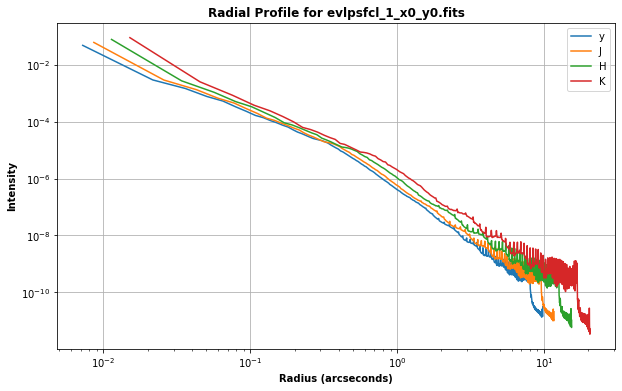

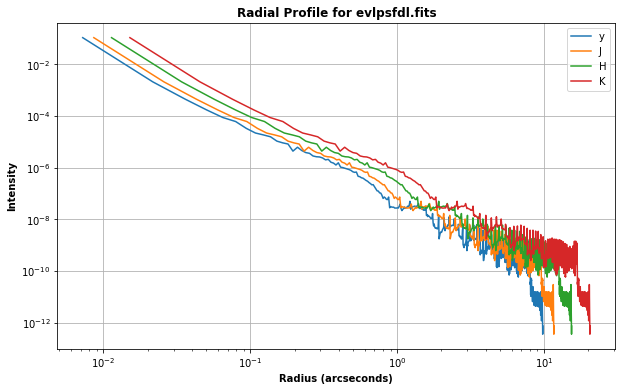

In [ ]:
plot_radial_profiles(test_results)

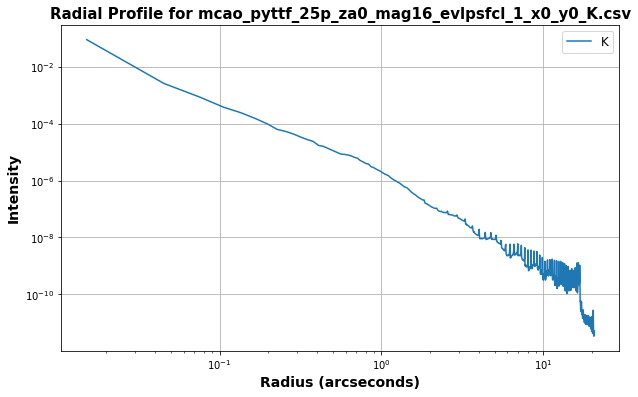

In [35]:
plot_from_csv(example_csv_file)

In [ ]:
# Example usage
current_directory = os.getcwd()
base_directory = current_directory
results = process_directory(base_directory)
plot_radial_profiles(results)

In [ ]:
def extract_number(filename):
    match = re.findall(r'\d+(?:\.\d+)?', filename)
    if match:
        return float(match[-1])

In [ ]:
extract_number("evl23psfcl_15.fits")

15.0

In [ ]:
def convert_files_to_csv(root_directory, output_directory):
    """Goes through a directory and converts FITS files to csv files containing the radii and profiles in a new folder."""
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Walk through the root directory
    for dirpath, dirnames, filenames in os.walk(root_directory):
        for file in filenames:
            # Check if the file is a FITS file and matches the desired pattern
            if file.endswith('_x0_y0.fits'):
                # Create the full path to the file
                full_path = os.path.join(dirpath, file)

                # Name the new file based on the folders it's in
                csv_name_base = convert_path_to_name(full_path)

                result = error_handled_fits(full_path)
                if result is not None:
                    # Get radii and profiles using the error_handled_fits function
                    radii, profiles = error_handled_fits(full_path)

                    # Create a DataFrame for each extension
                    for ext in radii.keys():
                        df = pd.DataFrame({
                            'Radius (arcsec)': radii[ext],
                            'Profile (intensity)': profiles[ext]
                        })

                        # Use the label mapping for the extension name
                        label = label_mapping.get(ext, ext)

                        # Create the new CSV filename with underscores
                        new_filename = f"{csv_name_base}_{label}.csv"

                        # Save the DataFrame to a CSV file in the output directory
                        csv_path = os.path.join(output_directory, new_filename)
                        df.to_csv(csv_path, index=False)

                        print(f"Converted {full_path} {ext} to {csv_path}")
                else: 
                    print(f"Error processing {full_path}")

In [ ]:
root_directory = "D:/mcao_pyttf/25p_za0/mag16"
output_directory = "C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files"
convert_files_to_csv(root_directory, output_directory)

Converted D:/mcao_pyttf/25p_za0/mag16\evlpsfcl_1_x0_y0.fits extension_0 to C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files\mcao_pyttf_25p_za0_mag16_evlpsfcl_1_x0_y0_y.csv
Converted D:/mcao_pyttf/25p_za0/mag16\evlpsfcl_1_x0_y0.fits extension_1 to C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files\mcao_pyttf_25p_za0_mag16_evlpsfcl_1_x0_y0_J.csv
Converted D:/mcao_pyttf/25p_za0/mag16\evlpsfcl_1_x0_y0.fits extension_2 to C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files\mcao_pyttf_25p_za0_mag16_evlpsfcl_1_x0_y0_H.csv
Converted D:/mcao_pyttf/25p_za0/mag16\evlpsfcl_1_x0_y0.fits extension_3 to C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files\mcao_pyttf_25p_za0_mag16_evlpsfcl_1_x0_y0_K.csv


In [ ]:
# Now see what happens if I give it a folder with an empty file
root_directory = "D:/mcao_pyttf/75p_za60/mag22"
output_directory = "C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files"
convert_files_to_csv(root_directory, output_directory)

File D:/mcao_pyttf/75p_za60/mag22\evlpsfcl_1_x0_y0.fits is empty.
Error processing D:/mcao_pyttf/75p_za60/mag22\evlpsfcl_1_x0_y0.fits


In [ ]:
test_path_str = "C:/folder1/folder2/filename.fits"
test_path = pathlib.Path(test_path_str)

In [ ]:
def remove_left_of_first_underscore(string):
    # Find the position of the first underscore
    first_underscore_index = string.find('_')
    
    # Return the substring from the first underscore to the end
    # If no underscore is found, return the original string
    if first_underscore_index != -1:
        return string[first_underscore_index + 1:]
    return string

In [ ]:
def convert_path_to_name(file_path_str):
    file_path = pathlib.Path(file_path_str)
    parent_path = file_path.parent
    subfolders_count = len([part for part in parent_path.parts if part != parent_path.drive])
    names = []
    # new_name = ""
    for i in range (0, subfolders_count+1):
        names.append(file_path.parts[i])

    new_name = "_".join(names)
    new_name = remove_left_of_first_underscore(new_name)
    
    if new_name.endswith('.fits'):
        return new_name[:-5]  # Remove the last 5 characters
    
    return new_name

In [ ]:
test_string = convert_path_to_name(test_path_str)
print(test_string)

folder1_folder2_filename


In [ ]:
remove_left_of_first_underscore(test_string)

'folder1_folder2_filename.fits'

In [ ]:
pathlib.Path(path_str).parts[-3]

'folder1'

Now make a function to plot from the csv files

In [33]:
def plot_from_csv(csv_file):
    """Plot the csv data to show radial profile."""
    # Read the CSV file, skipping the header row
    df = pd.read_csv(csv_file)

    # Assuming the CSV has two columns, use their names to access the data
    x = df.iloc[:, 0]  # First column
    y = df.iloc[:, 1]  # Second column
    band = csv_file.split('_')[-1][:-4]
    csv_name = os.path.basename(csv_file)

    plt.figure(figsize=(10, 6))
    plt.loglog(x, y, label = band)
    plt.xlabel('Radius (arcseconds)', fontweight='bold', fontsize=14)
    plt.ylabel('Intensity', fontweight='bold', fontsize=14)
    plt.title(f'Radial Profile for {csv_name}', fontweight='bold', fontsize=15)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

In [28]:
example_csv_file = 'C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files\mcao_pyttf_25p_za0_mag16_evlpsfcl_1_x0_y0_K.csv'

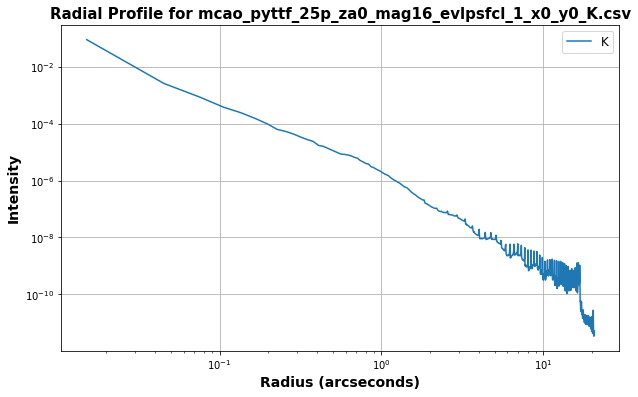

In [34]:
plot_from_csv(example_csv_file)

Now go through the whole folder at once for mcao

In [8]:
input_directory = "D:/mcao_pyttf"
output_directory = "C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files"
convert_files_to_csv(input_directory, output_directory)

Converted D:/mcao_pyttf\25p_za0\mag12\evlpsfcl_1_x0_y0.fits extension_0 to C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files\mcao_pyttf_25p_za0_mag12_evlpsfcl_1_x0_y0_y.csv
Converted D:/mcao_pyttf\25p_za0\mag12\evlpsfcl_1_x0_y0.fits extension_1 to C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files\mcao_pyttf_25p_za0_mag12_evlpsfcl_1_x0_y0_J.csv
Converted D:/mcao_pyttf\25p_za0\mag12\evlpsfcl_1_x0_y0.fits extension_2 to C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files\mcao_pyttf_25p_za0_mag12_evlpsfcl_1_x0_y0_H.csv
Converted D:/mcao_pyttf\25p_za0\mag12\evlpsfcl_1_x0_y0.fits extension_3 to C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files\mcao_pyttf_25p_za0_mag12_evlpsfcl_1_x0_y0_K.csv
Converted D:/mcao_pyttf\25p_za0\mag13\evlpsfcl_1_x0_y0.fits extension_0 to C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files\mcao_pyttf_25p_za0_mag13_evlpsfcl_1_x0_y0_y.csv
Converted D:/mcao_pyttf\25p_za0\mag13\evlpsfcl_1_x0_y0.fits extension_1 to C:/Us

In [9]:
input_directory = "D:/ngsao/ngsao"
output_directory = "C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files"
convert_files_to_csv(input_directory, output_directory)

Converted D:/ngsao/ngsao\25p_za0\mag10\evlpsfcl_1_x0_y0.fits extension_0 to C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files\ngsao_ngsao_25p_za0_mag10_evlpsfcl_1_x0_y0_y.csv
Converted D:/ngsao/ngsao\25p_za0\mag10\evlpsfcl_1_x0_y0.fits extension_1 to C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files\ngsao_ngsao_25p_za0_mag10_evlpsfcl_1_x0_y0_J.csv
Converted D:/ngsao/ngsao\25p_za0\mag10\evlpsfcl_1_x0_y0.fits extension_2 to C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files\ngsao_ngsao_25p_za0_mag10_evlpsfcl_1_x0_y0_H.csv
Converted D:/ngsao/ngsao\25p_za0\mag10\evlpsfcl_1_x0_y0.fits extension_3 to C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files\ngsao_ngsao_25p_za0_mag10_evlpsfcl_1_x0_y0_K.csv
Converted D:/ngsao/ngsao\25p_za0\mag11\evlpsfcl_1_x0_y0.fits extension_0 to C:/Users/Willi/Documents/Research/Specsim/contrast_csv_files\ngsao_ngsao_25p_za0_mag11_evlpsfcl_1_x0_y0_y.csv
Converted D:/ngsao/ngsao\25p_za0\mag11\evlpsfcl_1_x0_y0.fits extension